<center>
<h1> Credit Risk Analytics
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy

###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

<Figure size 720x540 with 0 Axes>

In [5]:
# Load the data
bankloans = pd.read_csv( 'bankloans.csv' )

In [6]:
bankloans.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [7]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [8]:
pandas_profiling.ProfileReport(bankloans)

Number of variables,9
Number of observations,850
Total Missing (%),2.0%
Total size in memory,59.8 KiB
Average record size in memory,72.1 B
Numeric,9
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [9]:
numeric_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]
print(numeric_var_names)
print(cat_var_names)

['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt', 'default']
[]


In [10]:
bankloans_num=bankloans[numeric_var_names]
bankloans_num.head(5)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [11]:
bankloans_cat = bankloans[cat_var_names]
bankloans_cat.head(5) # none as of now

""
0
1
2
3
4


In [12]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=bankloans_num.apply(lambda x: var_summary(x)).T

In [13]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [14]:
bankloans_existing = bankloans_num[bankloans_num.default.isnull()==0]
bankloans_new = bankloans_num[bankloans_num.default.isnull()==1]

In [15]:
#Handling Outliers - Method2
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

bankloans_existing=bankloans_existing.apply(lambda x: outlier_capping(x))

In [16]:
#Handling missings - Method2
def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x

bankloans_existing=bankloans_existing.apply(lambda x: Missing_imputation(x))

In [17]:
bankloans_existing.corr()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
age,1.000000,0.016576,0.537417,0.596973,0.521450,0.016926,0.308318,0.348911,-0.138654
ed,0.016576,1.000000,-0.158071,0.055560,0.225395,0.009992,0.103012,0.156523,0.118521
employ,0.537417,-0.158071,1.000000,0.324859,0.665369,-0.035332,0.405959,0.419337,-0.287197
address,0.596973,0.055560,0.324859,1.000000,0.345067,0.014967,0.215397,0.234896,-0.165389
income,0.521450,0.225395,0.665369,0.345067,1.000000,-0.022541,0.553114,0.626787,-0.099553
debtinc,0.016926,0.009992,-0.035332,0.014967,-0.022541,1.000000,0.534602,0.603630,0.388556
creddebt,0.308318,0.103012,0.405959,0.215397,0.553114,0.534602,1.000000,0.639984,0.238179
othdebt,0.348911,0.156523,0.419337,0.234896,0.626787,0.603630,0.639984,1.000000,0.138962
default,-0.138654,0.118521,-0.287197,-0.165389,-0.099553,0.388556,0.238179,0.138962,1.000000


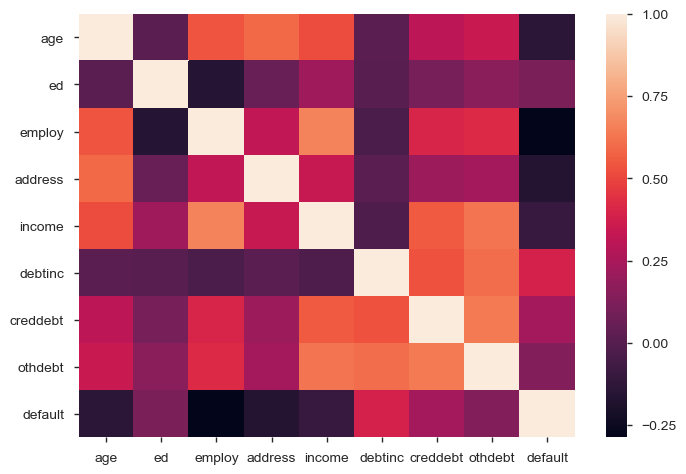

In [18]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bankloans_existing.corr())

###### 2.4 Data Exploratory Analysis
    - Variable Transformation: (i) Bucketing

In [19]:
bankloans_existing.columns.difference(['default'])

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

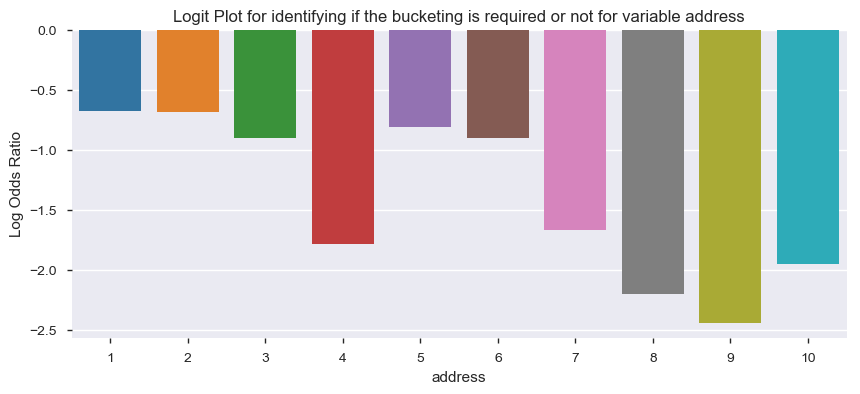

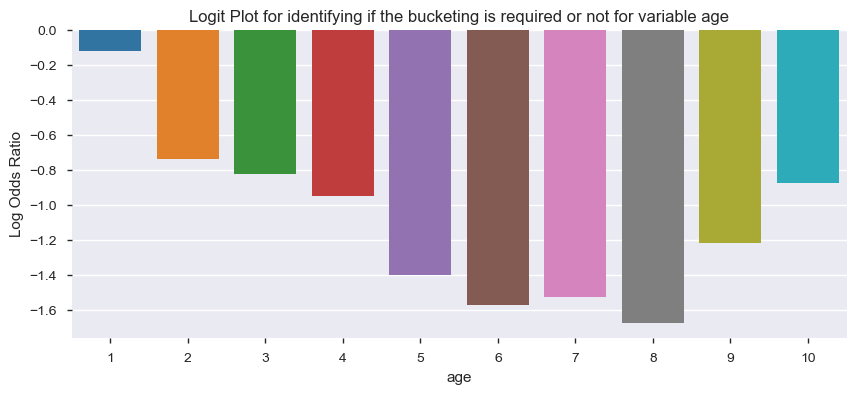

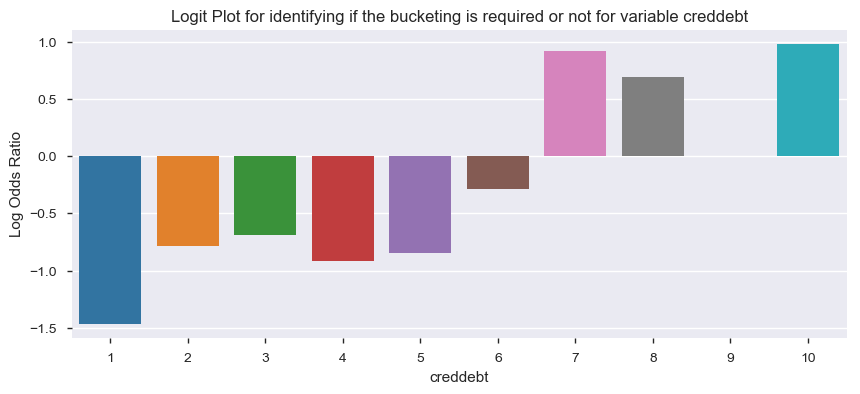

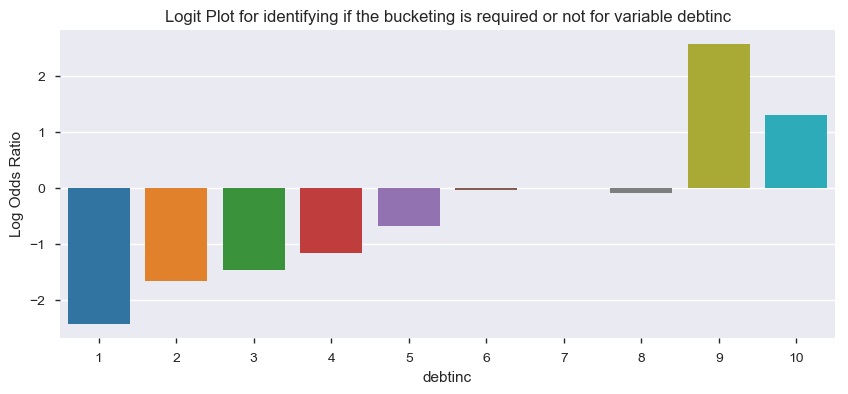

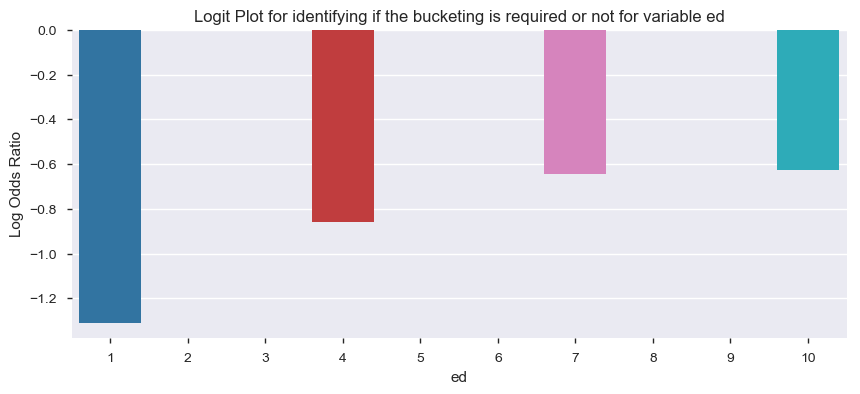

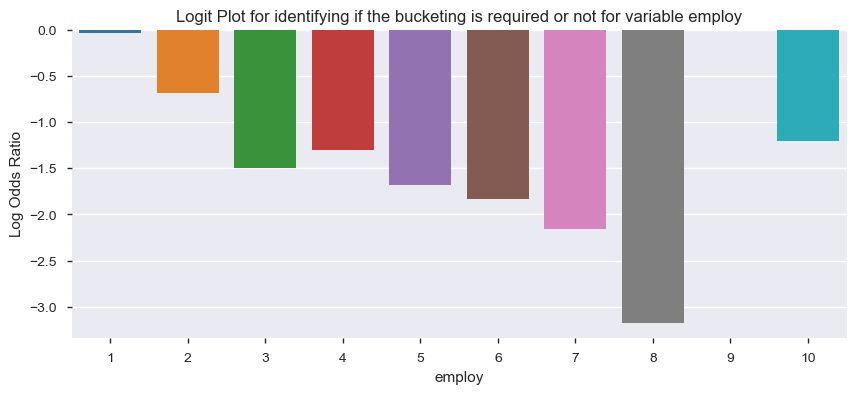

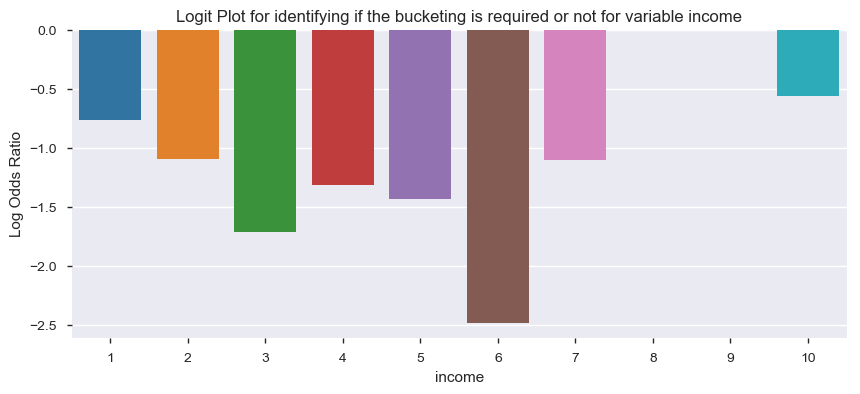

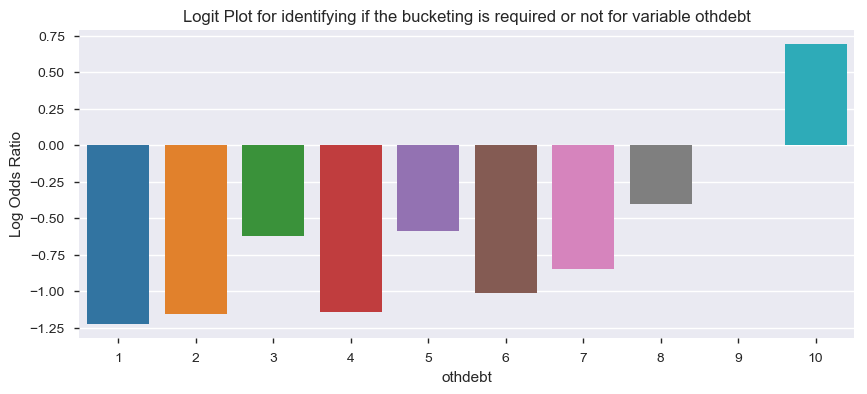

In [28]:
bp = PdfPages('Transformation Plots.pdf')

for num_variable in bankloans_existing.columns.difference(['default']):
    binned = pd.cut(bankloans_existing[num_variable], bins=10, labels=list(range(1,11)))
    #binned = binned.dropna()
    odds = bankloans_existing.groupby(binned)['default'].sum() / (bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
    log_odds = np.log(odds)
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=log_odds.index,y=log_odds)
    plt.ylabel('Log Odds Ratio')
    plt.title(str('Logit Plot for identifying if the bucketing is required or not for variable ') + str(num_variable))
    bp.savefig(fig)

bp.close()

###### 2.5 Data Exploratory Analysis
    - Variable Reduction using Somer's D values

In [29]:
bankloans_existing.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [30]:
logreg_model = sm.logit('default~address', data= bankloans_existing).fit()

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5


In [31]:
p = logreg_model.predict(bankloans_existing)

In [32]:
metrics.roc_auc_score(bankloans_existing['default'], p)

0.6111921446766232

In [33]:
2*metrics.roc_auc_score(bankloans_existing['default'], p)-1

0.2223842893532464

In [34]:
somersd_df = pd.DataFrame()
for num_variable in bankloans_existing.columns.difference(['default']):
    logreg = sm.logit(formula = str('default ~ ')+str(num_variable), data=bankloans_existing)
    result = logreg.fit()
    #summ = result.summary2()
    y_score = pd.DataFrame(result.predict())
    y_score.columns = ['Score']
    somers_d = 2*metrics.roc_auc_score(bankloans_existing['default'],y_score) - 1
    temp = pd.DataFrame([num_variable,somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

somersd_df

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


,Variable Name,SomersD
0,address,0.222384
0,age,0.206329
0,creddebt,0.272378
0,debtinc,0.470506
0,ed,0.148302
0,employ,0.409138
0,income,0.200273
0,othdebt,0.173806


In [35]:
## Variance Inflation Factor assessment
X = pd.concat([bankloans_existing[bankloans_existing.columns.difference(['default'])],bankloans_existing['default']], axis=1)
features = "+".join(bankloans_existing.columns.difference(['default']))
X.head()

,address,age,creddebt,debtinc,ed,employ,income,othdebt,default
0,12.0,41.0,9.891428,9.3,3,17.0,176.0,5.008608,1.0
1,6.0,27.0,1.362202,17.3,1,10.0,31.0,4.000798,0.0
2,14.0,40.0,0.856075,5.5,1,15.0,55.0,2.168925,0.0
3,14.0,41.0,2.658720,2.9,1,15.0,120.0,0.821280,0.0
4,0.0,24.0,1.787436,17.3,2,2.0,28.0,3.056564,1.0


In [36]:
features

'address+age+creddebt+debtinc+ed+employ+income+othdebt'

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
a,b = dmatrices(formula_like='default ~ '+ 'address+age+creddebt+debtinc+employ', 
                data = X, 
                return_type='dataframe')

a # contains only the Y variable
b # DF having all the X variables

,Intercept,address,age,creddebt,debtinc,employ
0,1.0,12.0,41.0,9.891428,9.3,17.00
1,1.0,6.0,27.0,1.362202,17.3,10.00
2,1.0,14.0,40.0,0.856075,5.5,15.00
3,1.0,14.0,41.0,2.658720,2.9,15.00
4,1.0,0.0,24.0,1.787436,17.3,2.00
5,1.0,5.0,41.0,0.392700,10.2,5.00
6,1.0,9.0,39.0,3.833874,30.6,20.00
7,1.0,11.0,43.0,0.128592,3.6,12.00
8,1.0,4.0,24.0,1.358348,24.4,3.00
9,1.0,13.0,36.0,2.777700,19.7,0.00


In [49]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

(vif)

,VIF Factor,features
0,28.170665,Intercept
1,1.557219,address
2,1.966746,age
3,1.903500,creddebt
4,1.570261,debtinc
5,1.673062,employ


In [ ]:
#Train and Test split
train, test = train_test_split(bankloans_existing, test_size=0.3, random_state=42)
train.columns

### Building logistic Regression

In [ ]:
logreg = sm.logit(formula='default ~ address+age+creddebt+debtinc+employ', data=train)
result = logreg.fit()

In [ ]:
 print(result.summary2())

- LE = -1.7615 -0.0839*address+0.0392*age+0.5996*creddebt+0.0710*debtinc-0.2541*employ
- p = exp(LE)/(1+exp(LE))

In [ ]:
train_gini = 2*metrics.roc_auc_score(train['default'], result.predict(train)) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test['default'], result.predict(test)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

In [ ]:
train_auc = metrics.roc_auc_score(train['default'], result.predict(train))
test_auc = metrics.roc_auc_score(test['default'], result.predict(test))

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)
                                 

In [ ]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train))
train_predicted_prob.columns = ['prob']
train_actual = train['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

In [ ]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test))
test_predicted_prob.columns = ['prob']
test_actual = test['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

In [ ]:
np.linspace(0,1,50)

In [ ]:
train_predict.head()
#cut-off = 0.2

In [ ]:
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 0.0 if x < 0.2 else 1.0)

In [ ]:
train_predict.head()

In [ ]:
train_predict['tp'] = train_predict.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
train_predict['fp'] = train_predict.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
train_predict['tn'] = train_predict.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
train_predict['fn'] = train_predict.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)

In [ ]:
train_predict.head(20)

In [ ]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1,50):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    accuracy = (train_temp['tp'].sum()  + train_temp['tn'].sum() ) / (train_temp['tp'].sum() + train_temp['fn'].sum() + train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [ ]:
roc_like_df

In [ ]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']

In [ ]:
roc_like_df.head()

In [ ]:
#Cut-off based on highest sum(sensitivity+specicity)   - common way of identifying cut-off
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

In [ ]:
#Cut-off based on highest accuracy   - some teams use this as methodology to decide the cut-off
roc_like_df[roc_like_df['accuracy']==roc_like_df['accuracy'].max()]

In [ ]:
#Cut-off based on highest sensitivity
roc_like_df[roc_like_df['sensitivity']==roc_like_df['sensitivity'].max()]

In [ ]:
#Choosen Best Cut-off is 0.23 based on highest (sensitivity+specicity)

In [ ]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)

In [ ]:
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()


In [ ]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

In [ ]:
metrics.classification_report?

In [ ]:
print(metrics.classification_report(train_predict.actual, train_predict.predicted))

In [ ]:
print(metrics.classification_report(test_predict.actual, test_predict.predicted))

### Decile Analysis

In [ ]:
#Decile analysis
#Top-two deciles - High risk customers - will reject applications
#3rd,4th, 5th deciesl - medium risk customers - will accept application with proper scrutin
#6th decile onwards - low risk customers - accept the applications


In [ ]:
#Decile analysis for validation of models - Business validation

In [ ]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)

In [ ]:
train_predict.head()

In [ ]:
test_predict['Deciles']=pd.qcut(test_predict['prob'],10, labels=False)

test_predict.head()

In [ ]:
# Decile Analysis for train data

In [ ]:
no_1s = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)['actual']
no_total = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).count().sort_index(ascending=False)['actual']
max_prob = train_predict[['Deciles','prob']].groupby(train_predict.Deciles).max().sort_index(ascending=False)['prob']
min_prob = train_predict[['Deciles','prob']].groupby(train_predict.Deciles).min().sort_index(ascending=False)['prob']

In [ ]:
Decile_analysis_train = pd.concat([max_prob, min_prob, no_1s, no_total-no_1s, no_total], axis=1)

In [ ]:
Decile_analysis_train

In [ ]:
# Decile Analysis for train data

no_1s = test_predict[['Deciles','actual']].groupby(test_predict.Deciles).sum().sort_index(ascending=False)['actual']
no_total = test_predict[['Deciles','actual']].groupby(test_predict.Deciles).count().sort_index(ascending=False)['actual']
max_prob = test_predict[['Deciles','prob']].groupby(test_predict.Deciles).max().sort_index(ascending=False)['prob']
min_prob = test_predict[['Deciles','prob']].groupby(test_predict.Deciles).min().sort_index(ascending=False)['prob']

Decile_analysis_test = pd.concat([max_prob, min_prob, no_1s, no_total-no_1s, no_total], axis=1)

Decile_analysis_test

In [ ]:
Decile_analysis_train.to_csv('Decile_analysis_train.csv')

In [ ]:
Decile_analysis_test.to_csv('Decile_analysis_test.csv')

In [ ]:
#Exercise
#you need to come up with the similar metrics for train & test as per the template
# you need to compare Bad rate, lift, KS, Rank ordering for train & test decile analysis

## Predicting new customers (Implementation of Model on new data)

In [ ]:
# predciting new customers good or bad
bankloans_new.head()

In [ ]:
#before scoring new customers, you need to process the data using the sames steps you followed while building the model
#Excercise


In [ ]:
bankloans_new['prob'] = result.predict(bankloans_new)

In [ ]:
bankloans_new.head()

In [ ]:
bankloans_new['default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.23 else 0)

In [ ]:
bankloans_new.head()

In [ ]:
bankloans_new.default.value_counts()

In [ ]:
#We are rejecting applications for 67 customers based on cut-off = 0.23